## Import Libraries

In [1]:
# Matrix operations
import pandas as pd
import numpy as np


# Preprocessing
import category_encoders as ce 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from corr_code import get_cat_correlated_cols,get_correlated_cols

# Metrics 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_log_error,make_scorer

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, Lars, LarsCV

In [81]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [56]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

### Load Data 

In [3]:
train = pd.read_csv("data/Train.csv")
test = pd.read_csv("data/Test.csv")

# SHape
print("Train Shape ",train.shape)
print("Test Shape ",test.shape)

Train Shape  (21000, 15)
Test Shape  (9000, 14)


In [4]:
# Target Columns
target = "Per Person Price"
train.head(3)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5


## Variables

In [5]:
#Drop Uniq Id
train.drop('Uniq Id',axis=1, inplace=True)
test.drop('Uniq Id',axis=1, inplace=True)

In [6]:
# Travel Date
train['Travel Date'] = pd.to_datetime(train['Travel Date'])
test['Travel Date'] = pd.to_datetime(test['Travel Date'])

In [7]:
# Feature Extraction 
train['td_year'] = train['Travel Date'].dt.year
train['td_month'] = train['Travel Date'].dt.month
train['td_weekday'] = train['Travel Date'].dt.weekday

test['td_year'] = test['Travel Date'].dt.year
test['td_month'] = test['Travel Date'].dt.month
test['td_weekday'] = test['Travel Date'].dt.weekday

In [8]:
train.drop(['Travel Date'],axis=1,inplace=True)
test.drop(['Travel Date'],axis=1,inplace=True)

### Feature Engineering

In [9]:
# Drop Correlated Columns

In [10]:
num_drop_cols = get_correlated_cols(train,.9)


In [11]:
num_drop_cols

[]

In [12]:

cat_cols = ['Package Name', 'Package Type', 'Destination', 'Itinerary',
       'Places Covered', 'Hotel Details', 'Start City',
       'Airline', 'Flight Stops', 'Meals', 'Sightseeing Places Covered',
       'Cancellation Rules']
corr_map,cat_drop_cols = get_cat_correlated_cols(train,cat_cols,.9)

In [13]:
cat_drop_cols

{'Destination',
 'Flight Stops',
 'Itinerary',
 'Meals',
 'Places Covered',
 'Sightseeing Places Covered'}

In [14]:
cat_drop_cols.remove('Itinerary')
cat_drop_cols.add('Destination')

In [15]:
cols_to_drop = num_drop_cols + list(cat_drop_cols)

print("Columns to Drop  ", cols_to_drop)

Columns to Drop   ['Sightseeing Places Covered', 'Meals', 'Flight Stops', 'Places Covered', 'Destination']


In [92]:
# Drop the correlated columns
train1 = train.drop(cat_drop_cols,axis=1)
test1 = test.drop(cat_drop_cols,axis=1)

train2 = train.drop(cat_drop_cols,axis=1)
test2 = test.drop(cat_drop_cols,axis=1)

### Outlier Removal

In [93]:
train1.head()

,Package Name,Package Type,Itinerary,Hotel Details,Start City,Airline,Cancellation Rules,Per Person Price,td_year,td_month,td_weekday
0,Best of Shimla and Manali Holiday from Delhi,Standard,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,Not Available,Mumbai,Not Available,Not Available,11509.0,2021,7,4
1,Kashmir Valley vacation,Premium,1N Srinagar . 2N Pahalgam . 1N Srinagar,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,Cancellation any time after making the 1st pay...,22485.5,2021,8,3
2,Might of Mewar- Udaipur and Chittorgarh,Luxury,2N Udaipur . 1N Chittorgarh,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,Cancellation any time after making the 1st pay...,12421.5,2021,4,0
3,Colorful Kerala ( Romantic Getaway ),Premium,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,Cancellation any time after making the 1st pay...,35967.0,2021,8,4
4,A Week In Bangkok & Pattaya,Premium,4N Pattaya . 3N Bangkok,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,Cancellation any time after making the 1st pay...,25584.0,2021,12,6


### Extract Features. 

In [94]:
train1['no_places'] = train1['Itinerary'].apply(lambda x : len(x.split(".")))
test1['no_places'] = test1['Itinerary'].apply(lambda x : len(x.split(".")))


In [95]:
train1['no_airline'] =  train1['Airline'].apply(lambda x : len(x.split("|")))
test1['no_airline'] = test1['Airline'].apply(lambda x : len(x.split("|")))

In [96]:
train1['ttl_nights'] =  train1['Itinerary'].apply(lambda x : sum(map(int,re.findall(r"[\d+]+",x))))
test1['ttl_nights'] = test1['Itinerary'].apply(lambda x : sum(map(int,re.findall(r"[\d+]+",x))))

In [97]:
destinations = set('|'.join(train['Destination']).split('|'))
train1[list(destinations)] = [0]*len(destinations)
test1[list(destinations)] = [0]*len(destinations)

for i in range(train1.shape[0]):
    dests = train1.loc[i,'Itinerary']
    for dest in dests.split(' . '):
        val,key = int(dest[0]), dest[3:]
        if key not in destinations:
            print(i)
        train1.loc[i,key] = val 
for i in range(test1.shape[0]):
    dests = test1.loc[i,'Itinerary']
    for dest in dests.split(' . '):
        val,key = int(dest[0]), dest[3:]
        if key not in destinations:
            print(i)
        test1.loc[i,key] = val 

In [98]:
airlines = set('|'.join(train1['Airline']).split('|'))

In [99]:
train1[list(airlines)] = [0]*len(airlines)
test1[list(airlines)] = [0]*len(airlines)

In [100]:
for i in range(train1.shape[0]):
    dests = train1.loc[i,'Airline']
    for dest in dests.split('|'):
        if dest not in airlines:
            print(i)
        train1.loc[i,dest] =1 
for i in range(test1.shape[0]):
    dests = test1.loc[i,'Airline']
    for dest in dests.split('|'):
        if dest not in airlines:
            print(i)
        test1.loc[i,dest] +=1 

In [101]:
train1.columns

Index(['Package Name', 'Package Type', 'Itinerary', 'Hotel Details',
       'Start City', 'Airline', 'Cancellation Rules', 'Per Person Price',
       'td_year', 'td_month',
       ...
       'Thai Vietjet Air', 'Malaysia Airlines', 'Air New Zealand',
       'Air Baltic', 'Qatar Airways', 'Airconnect', 'China Eastern',
       'Turkish Airlines', 'Srilankan Airlines', 'Swiss'],
      dtype='object', length=252)

In [102]:
train2 = train1.drop(['Package Name','Itinerary','Hotel Details','Airline','Cancellation Rules'],axis=1)
test2 = test1.drop(['Package Name','Itinerary','Hotel Details','Airline','Cancellation Rules'],axis=1)

## Modeling 1 

In [103]:
train2.columns

Index(['Package Type', 'Start City', 'Per Person Price', 'td_year', 'td_month',
       'td_weekday', 'no_places', 'no_airline', 'ttl_nights',
       'Saint Petersburg',
       ...
       'Thai Vietjet Air', 'Malaysia Airlines', 'Air New Zealand',
       'Air Baltic', 'Qatar Airways', 'Airconnect', 'China Eastern',
       'Turkish Airlines', 'Srilankan Airlines', 'Swiss'],
      dtype='object', length=247)

In [104]:
train2.head()

,Package Type,Start City,Per Person Price,td_year,td_month,td_weekday,no_places,no_airline,ttl_nights,Saint Petersburg,...,Thai Vietjet Air,Malaysia Airlines,Air New Zealand,Air Baltic,Qatar Airways,Airconnect,China Eastern,Turkish Airlines,Srilankan Airlines,Swiss
0,Standard,Mumbai,11509.0,2021,7,4,4,1,6,0,...,0,0,0,0,0,0,0,0,0,0
1,Premium,New Delhi,22485.5,2021,8,3,3,2,4,0,...,0,0,0,0,0,0,0,0,0,0
2,Luxury,New Delhi,12421.5,2021,4,0,2,1,3,0,...,0,0,0,0,0,0,0,0,0,0
3,Premium,New Delhi,35967.0,2021,8,4,4,1,6,0,...,0,0,0,0,0,0,0,0,0,0
4,Premium,New Delhi,25584.0,2021,12,6,2,2,7,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='Per Person Price', ylabel='Count'>

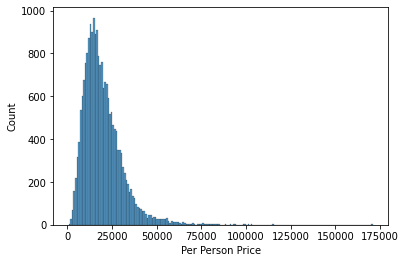

In [105]:
sns.histplot(train2[target])

In [106]:

#cat_cols = ['Package Type', 'Start City','td_year','td_weekday','td_month']
cat_cols= ['Package Type','Start City']

In [107]:
z = np.abs(stats.zscore(train2[target]))
train2 = train2[z<3]

In [108]:
X = train2.drop(['Per Person Price'],axis=1)
y = train2['Per Person Price']
y1=np.log1p(y)
Xt = test2[X.columns]

In [109]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y1,test_size=.2)

In [110]:
cat_idx = []
for col in cat_cols:
    cat_idx.append(X.columns.get_loc(col))

print("Category Indexes ",cat_idx)

Category Indexes  [0, 1]


In [111]:
rpipe = Pipeline(steps=[('encoder',ce.CatBoostEncoder(cols=cat_cols)),
                       ('scaler',StandardScaler()),
                       ('model',Ridge())
                        ])

In [132]:
cat_pipe = CatBoostRegressor(iterations=5000,verbose=500,cat_features=cat_idx)

In [112]:
lass_pipe = Pipeline(steps=[('encoder',ce.CatBoostEncoder(cols=cat_cols)),
                       ('scaler',StandardScaler()),
                       ('model',Lasso())
                        ])

In [113]:
def custom_msle(y,yhat):
    y, yhat = np.expm1(y), np.expm1(yhat)
    return mean_squared_log_error(y,yhat)
rmsle = make_scorer(custom_msle)

In [114]:
scoring = "neg_mean_squared_log_error"

mdl = CatBoostRegressor(cat_features=cat_idx,verbose=500)
cv_score = cross_val_score(rpipe,X,y1,scoring = rmsle,cv=3)

C:\Users\Vivek.ananthan\Anaconda3\envs\deepcpu\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Vivek.ananthan\Anaconda3\envs\deepcpu\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Vivek.ananthan\Anaconda3\envs\deepcpu\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [115]:
print(" Ridge model")
print("cv_score " ,cv_score)
print("cv meann",cv_score.mean())
print("cv std",cv_score.std())

 Ridge model
cv_score  [0.05773945 0.05854274 0.06298603]
cv meann 0.05975607221603354
cv std 0.0023073481069501196


In [116]:
rpipe.fit(X,y1)

C:\Users\Vivek.ananthan\Anaconda3\envs\deepcpu\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('encoder',
                 CatBoostEncoder(cols=['Package Type', 'Start City'])),
                ('scaler', StandardScaler()), ('model', Ridge())])

In [133]:
cat_pipe.fit(X,y1)

Learning rate set to 0.019695
0:	learn: 0.5109686	total: 48.9ms	remaining: 4m 4s
500:	learn: 0.2148451	total: 31.8s	remaining: 4m 45s
1000:	learn: 0.1959007	total: 1m 5s	remaining: 4m 20s
1500:	learn: 0.1870274	total: 1m 33s	remaining: 3m 38s
2000:	learn: 0.1813374	total: 2m 4s	remaining: 3m 6s
2500:	learn: 0.1770881	total: 2m 33s	remaining: 2m 32s
3000:	learn: 0.1737692	total: 3m 3s	remaining: 2m 2s
3500:	learn: 0.1708539	total: 3m 32s	remaining: 1m 30s
4000:	learn: 0.1683932	total: 4m 3s	remaining: 1m
4500:	learn: 0.1660643	total: 4m 40s	remaining: 31s
4999:	learn: 0.1640094	total: 5m 15s	remaining: 0us


In [118]:
yhat = rpipe.predict(xtest
                    )

In [126]:
res = pd.DataFrame()
res[target]=np.expm1(rpipe.predict(Xt))
res.to_csv("ridge_pipe_zscore.csv",index=False)

In [134]:
res = pd.DataFrame()
res[target]=np.expm1(cat_pipe.predict(Xt))
res.to_csv("catpips.csv",index=False)

In [121]:
res = ytest-yhat
res_abs = abs(ytest-yhat)
res_exp = np.expm1(ytest)-np.expm1(yhat)

<AxesSubplot:ylabel='Frequency'>

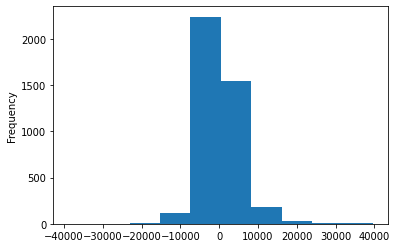

In [122]:
res_exp.plot(kind='hist')

C:\Users\Vivek.ananthan\Anaconda3\envs\deepcpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


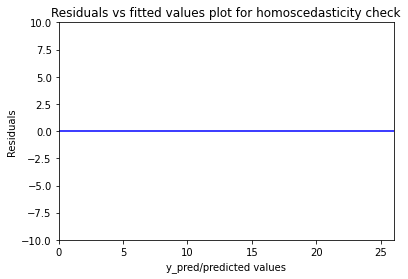

In [123]:
p = sns.scatterplot(x=np.expm1(yhat),y=np.expm1(res))
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

<AxesSubplot:xlabel='Per Person Price', ylabel='Count'>

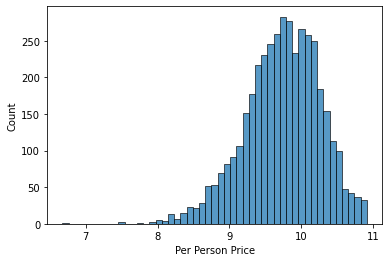

In [124]:
sns.histplot(ytest)

<AxesSubplot:ylabel='Count'>

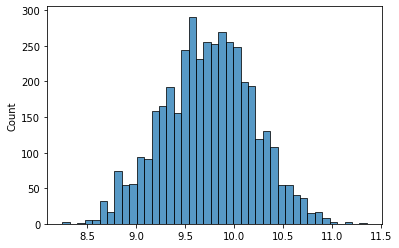

In [125]:
sns.histplot(yhat)